**Assignment 2: Convolution**

By: Arvind Chaurasia and Harika Beesetti

*As you saw in the chapter “Deep learning for computer vision,” convents can be used successfully to classify images. Specifically, consider the Cats & Dogs example. There were two broad approaches to classifying Cats & Dogs usings convnets: Training a network from scratch, versus using a pretrained convnet. While small datasets can lead to overfitting, thus making training a network for prediction more difficult, you also saw several techniques to reduce overfitting, and these include data augmentation and regularization.*

*In this assignment, you will examine the relationship between training samples and the choice of training your model from scratch, versus using a pretrained convnet. Specifically, answer the following questions:*

*1. Consider the Cats & Dogs example. Start initially with a training sample of 1000, a validation sample of 500, and a test sample of 500 (like in the text). Use any technique to reduce overfitting and improve performance in developing a network that you train from scratch. What performance did you achieve?*

In [1]:
#Lest's use Kaggle API which will eliminate the maual authentication

import os
os.environ['KAGGLE_CONFIG_DIR'] = '/content'

In [2]:
#Using API of the dataset
!kaggle competitions download -c dogs-vs-cats

100% 812M/812M [00:28<00:00, 51.2MB/s]
100% 812M/812M [00:28<00:00, 30.0MB/s]


In [3]:
#Now we will unzip all the file for data set.
!unzip /content/dogs-vs-cats.zip

Archive:  /content/dogs-vs-cats.zip
  inflating: sampleSubmission.csv    
  inflating: test1.zip               
  inflating: train.zip               


In [4]:
!unzip /content/test1.zip
!unzip /content/train.zip

Streaming output truncated to the last 5000 lines.
  inflating: train/dog.5499.jpg      
  inflating: train/dog.55.jpg        
  inflating: train/dog.550.jpg       
  inflating: train/dog.5500.jpg      
  inflating: train/dog.5501.jpg      
  inflating: train/dog.5502.jpg      
  inflating: train/dog.5503.jpg      
  inflating: train/dog.5504.jpg      
  inflating: train/dog.5505.jpg      
  inflating: train/dog.5506.jpg      
  inflating: train/dog.5507.jpg      
  inflating: train/dog.5508.jpg      
  inflating: train/dog.5509.jpg      
  inflating: train/dog.551.jpg       
  inflating: train/dog.5510.jpg      
  inflating: train/dog.5511.jpg      
  inflating: train/dog.5512.jpg      
  inflating: train/dog.5513.jpg      
  inflating: train/dog.5514.jpg      
  inflating: train/dog.5515.jpg      
  inflating: train/dog.5516.jpg      
  inflating: train/dog.5517.jpg      
  inflating: train/dog.5518.jpg      
  inflating: train/dog.5519.jpg      
  inflating: train/dog.552.jpg       

Now we will be copying images to training, validation, and test directories.

In [5]:
#Importing Modules
import os, shutil, pathlib

#Setting Up Paths
original_dir = pathlib.Path("train")
new_base_dir = pathlib.Path("cats_vs_dogs_small")

#Defining a Function to Create Subsets
def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir)
        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=original_dir / fname,
                            dst=dir / fname)

#Calling the Function to Create Subsets
make_subset("train", start_index=0, end_index=1000)
make_subset("validation", start_index=1000, end_index=1500)
make_subset("test", start_index=1500, end_index=2000)

Let's visualize some of the images.

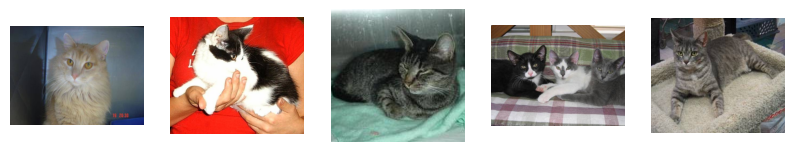

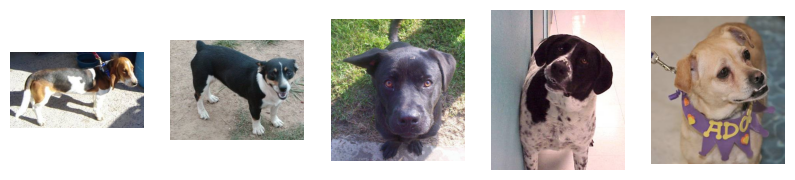

In [6]:
import matplotlib.pyplot as plt
from PIL import Image

def plot_images(subset_name, category, num_images=5):
    subset_dir = new_base_dir / subset_name / category
    image_files = list(subset_dir.glob("*.jpg"))[:num_images]
    plt.figure(figsize=(10, 5))
    for i, image_file in enumerate(image_files, 1):
        image = Image.open(image_file)
        plt.subplot(1, num_images, i)
        plt.imshow(image)
        plt.axis("off")
    plt.show()

# Plot some images from the "train" subset
plot_images("train", "cat")
plot_images("train", "dog")


Data preprocessing


We will be using image_dataset_from_directory to read images

In [7]:
#Importing the Utility
from tensorflow.keras.utils import image_dataset_from_directory

#Creating Image Datasets
train_dataset = image_dataset_from_directory(
    new_base_dir / "train",
    image_size=(180, 180),
    batch_size=32)

validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation",
    image_size=(180, 180),
    batch_size=32)

test_dataset = image_dataset_from_directory(
    new_base_dir / "test",
    image_size=(180, 180),
    batch_size=32)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


In [8]:
#Importing Libraries
import numpy as np
import tensorflow as tf

#Generating Random Numbers
random_numbers = np.random.normal(size=(1000, 16))

#Creating a TensorFlow Dataset
dataset = tf.data.Dataset.from_tensor_slices(random_numbers)

In [9]:
#Iteration and Indexing

for i, element in enumerate(dataset):
    print(element.shape)
    if i >= 2:
        break

(16,)
(16,)
(16,)


In [10]:
#Creating a Batched Dataset

batched_dataset = dataset.batch(32)
for i, element in enumerate(batched_dataset):
    print(element.shape)
    if i >= 2:
        break

(32, 16)
(32, 16)
(32, 16)


In [11]:
#Reshaping Elements with map

reshaped_dataset = dataset.map(lambda x: tf.reshape(x, (4, 4)))
for i, element in enumerate(reshaped_dataset):
    print(element.shape)
    if i >= 2:
        break

(4, 4)
(4, 4)
(4, 4)


Further displaying the shapes of the data and labels yielded by the Dataset

In [12]:
for data_batch, labels_batch in train_dataset:
    print("data batch shape is", data_batch.shape)
    print("labels batch shape is", labels_batch.shape)
    break

data batch shape is (32, 180, 180, 3)
labels batch shape is (32,)


Building our model

A small convnet for dogs vs. cats classification model using Convolutional Neural Network (CNN).

In [13]:
#Importing Libraries
from tensorflow import keras
from tensorflow.keras import layers

#Input Layer
inputs = keras.Input(shape=(180, 180, 3))

#Rescaling
h = layers.Rescaling(1./255)(inputs)

#Convolutional Layers
h = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(h)
h = layers.MaxPooling2D(pool_size=2)(h)
h = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(h)
h = layers.MaxPooling2D(pool_size=2)(h)
h = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(h)
h = layers.MaxPooling2D(pool_size=2)(h)
h = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(h)
h = layers.MaxPooling2D(pool_size=2)(h)
h = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(h)

#Flattening
h = layers.Flatten()(h)

#Output Layer
outputs = layers.Dense(1, activation="sigmoid")(h)

#Model Creation
model = keras.Model(inputs=inputs, outputs=outputs)

Let's print a summary of the model's architecture.

In [14]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 89, 89, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 43, 43, 64)        0         
 g2D)                                                        

Configuring the model for training

In [15]:
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop", #Please note that we can use "adam" as well
              metrics=["accuracy"])

Fitting the model



In [16]:
#Model Checkpoint Callback
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch.keras",
        save_best_only=True,
        monitor="val_loss")
]

#Model Fitting
history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks)

#We can also consider using additional callbacks like EarlyStopping to stop training early if the validation loss doesn't improve for a certain number of epochs.

Epoch 1/30
63/63 [==============================] - 13s 112ms/step - loss: 0.6945 - accuracy: 0.5055 - val_loss: 0.6920 - val_accuracy: 0.5370
Epoch 2/30
63/63 [==============================] - 7s 108ms/step - loss: 0.6929 - accuracy: 0.5450 - val_loss: 0.6703 - val_accuracy: 0.5700
Epoch 3/30
63/63 [==============================] - 6s 85ms/step - loss: 0.6403 - accuracy: 0.6410 - val_loss: 0.6799 - val_accuracy: 0.5950
Epoch 4/30
63/63 [==============================] - 7s 110ms/step - loss: 0.6179 - accuracy: 0.6570 - val_loss: 0.6172 - val_accuracy: 0.6370
Epoch 5/30
63/63 [==============================] - 5s 70ms/step - loss: 0.5774 - accuracy: 0.6950 - val_loss: 0.6003 - val_accuracy: 0.6610
Epoch 6/30
63/63 [==============================] - 4s 60ms/step - loss: 0.5644 - accuracy: 0.6985 - val_loss: 0.6406 - val_accuracy: 0.6290
Epoch 7/30
63/63 [==============================] - 5s 82ms/step - loss: 0.5421 - accuracy: 0.7165 - val_loss: 0.7230 - val_accuracy: 0.6180
Epoch 8/3

Let's display the curves of loss and accuracy during training

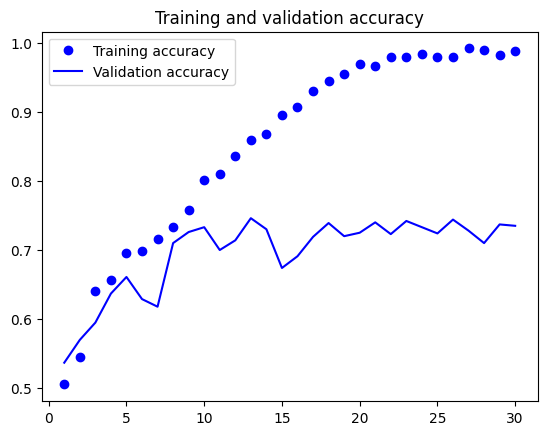

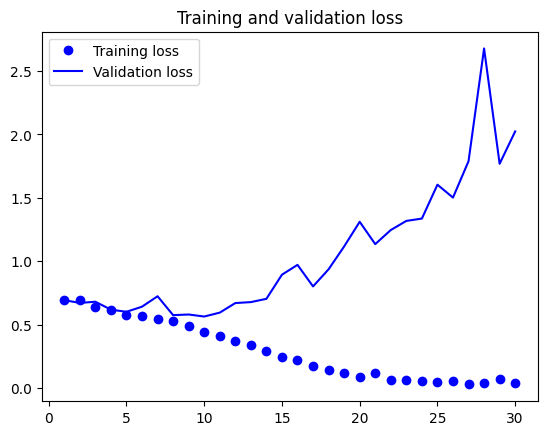

In [17]:
#Importing Libraries
import matplotlib.pyplot as plt

#Extracting Training Data
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]

#Defining Epochs
epochs = range(1, len(accuracy) + 1)

#Plotting Accuracy
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()

#Plotting Loss
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

Further, evaluating our model on the test set.



In [18]:
#Loading the Model
test_model = keras.models.load_model("convnet_from_scratch.keras")

#Evaluating the Model
test_loss, test_acc = test_model.evaluate(test_dataset)

#Printing Test Accuracy
print(f"Test accuracy: {test_acc:.3f}")

32/32 [==============================] - 3s 52ms/step - loss: 0.5852 - accuracy: 0.7250
Test accuracy: 0.725


In [19]:
#Save model
model.save('Q1_cats_vs_dogs.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Let's use dropout method to prevent overfitting.

In [20]:
from tensorflow import keras
from tensorflow.keras import layers

# Input Layer
inputs = keras.Input(shape=(180, 180, 3))

# Rescaling
h = layers.Rescaling(1./255)(inputs)

# Convolutional Layers
h = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(h)
h = layers.MaxPooling2D(pool_size=2)(h)
h = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(h)
h = layers.MaxPooling2D(pool_size=2)(h)
h = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(h)
h = layers.MaxPooling2D(pool_size=2)(h)
h = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(h)
h = layers.MaxPooling2D(pool_size=2)(h)
h = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(h)

# Flattening
h = layers.Flatten()(h)

# Dropout
h = layers.Dropout(0.5)(h)  # Adding Dropout after flattening

# Output Layer
outputs = layers.Dense(1, activation="sigmoid")(h)

# Model Creation
model = keras.Model(inputs=inputs, outputs=outputs)


In [21]:
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop", #Please note that we can use "adam" as well
              metrics=["accuracy"])

In [22]:
#Model Checkpoint Callback
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch.keras",
        save_best_only=True,
        monitor="val_loss")
]

#Model Fitting
history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/30
63/63 [==============================] - 7s 67ms/step - loss: 0.7124 - accuracy: 0.5025 - val_loss: 0.6929 - val_accuracy: 0.5000
Epoch 2/30
63/63 [==============================] - 4s 65ms/step - loss: 0.6936 - accuracy: 0.5275 - val_loss: 0.6854 - val_accuracy: 0.5560
Epoch 3/30
63/63 [==============================] - 7s 112ms/step - loss: 0.6823 - accuracy: 0.5690 - val_loss: 0.7731 - val_accuracy: 0.5010
Epoch 4/30
63/63 [==============================] - 4s 61ms/step - loss: 0.6555 - accuracy: 0.6200 - val_loss: 0.8115 - val_accuracy: 0.5560
Epoch 5/30
63/63 [==============================] - 4s 63ms/step - loss: 0.6352 - accuracy: 0.6510 - val_loss: 0.5979 - val_accuracy: 0.6780
Epoch 6/30
63/63 [==============================] - 7s 111ms/step - loss: 0.5959 - accuracy: 0.6860 - val_loss: 0.6010 - val_accuracy: 0.6790
Epoch 7/30
63/63 [==============================] - 5s 74ms/step - loss: 0.5608 - accuracy: 0.7080 - val_loss: 0.5952 - val_accuracy: 0.6790
Epoch 8/30


In [23]:
#Loading the Model
test_model = keras.models.load_model("convnet_from_scratch.keras")

#Evaluating the Model
test_loss, test_acc = test_model.evaluate(test_dataset)

#Printing Test Accuracy
print(f"Test accuracy: {test_acc:.3f}")

32/32 [==============================] - 1s 30ms/step - loss: 0.6076 - accuracy: 0.7050
Test accuracy: 0.705


*2. Increase your training sample size. You may pick any amount. Keep the validation and test samples the same as above. Optimize your network (again training from scratch). What performance did you achieve?*

In this question we will increase the training sample size without making any changes to the test and validation sample same.

In [24]:
#Importing Libraries
import os, shutil, pathlib

#Defining Paths
original_dir = pathlib.Path("train")
new_base_dir = pathlib.Path("cats_vs_dogs_small_2")

#Creating a Subset Function
def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir)
        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=original_dir / fname,
                            dst=dir / fname)

#Creating Training, Validation, and Test Sets
make_subset("train", start_index=0, end_index=2000)
make_subset("validation", start_index=2000, end_index=2500)
make_subset("test", start_index=2500, end_index=3000)

In this part of the question we will apply be using data augmentation as well in order to combat the overfitting.

Define a data augmentation stage to add to an image model

In [25]:
#Data Augmentation with keras.Sequential

data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

Now we will be displaying some randomly augmented training images from our dataset.



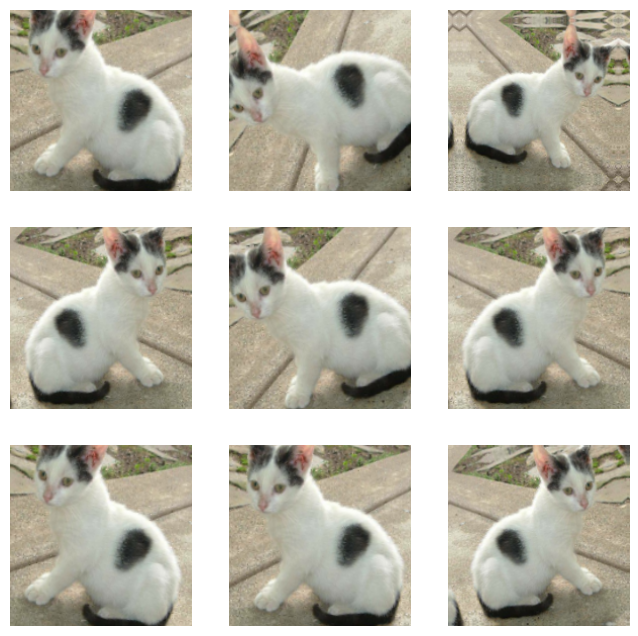

In [26]:
#Setting Up the Plot
plt.figure(figsize=(8, 8)) #Please note that this size can be adjusted

#Looping Through Training Images and Applying Augmentation & Plotting
for images, _ in train_dataset.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

Now, we have define a new convnet that includes image augmentation and dropout



In [27]:
#Model Definition
inputs = keras.Input(shape=(180, 180, 3))

#Data Augmentation
i = data_augmentation(inputs)

#Preprocessing
i = layers.Rescaling(1./255)(i)

#Convolutional Layers
i = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(i)
i = layers.MaxPooling2D(pool_size=2)(i)
i = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(i)
i = layers.MaxPooling2D(pool_size=2)(i)
i = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(i)
i = layers.MaxPooling2D(pool_size=2)(i)
i = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(i)
i = layers.MaxPooling2D(pool_size=2)(i)
i = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(i)

#Flattening and Dropout
i = layers.Flatten()(i)
i = layers.Dropout(0.5)(i)

#Output Layer
outputs = layers.Dense(1, activation="sigmoid")(i)

#Model Creation and Summary
model = keras.Model(inputs=inputs, outputs=outputs)
model.summary()

#Model Compilation
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 180, 180, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_10 (Conv2D)          (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 89, 89, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 87, 87, 64)        18496     
                                                           


Training the regularized convnet



In [28]:
#Model Checkpoint Callback
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch_with_augmentation.keras",
        save_best_only=True,
        monitor="val_loss")
]

#Model Fitting
history = model.fit(
    train_dataset,
    epochs=50,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/50
63/63 [==============================] - 8s 95ms/step - loss: 0.6965 - accuracy: 0.4970 - val_loss: 0.6928 - val_accuracy: 0.5000
Epoch 2/50
63/63 [==============================] - 7s 106ms/step - loss: 0.6937 - accuracy: 0.5045 - val_loss: 0.6927 - val_accuracy: 0.5000
Epoch 3/50
63/63 [==============================] - 4s 62ms/step - loss: 0.6921 - accuracy: 0.5285 - val_loss: 0.7425 - val_accuracy: 0.5010
Epoch 4/50
63/63 [==============================] - 4s 64ms/step - loss: 0.6846 - accuracy: 0.5635 - val_loss: 0.6579 - val_accuracy: 0.6390
Epoch 5/50
63/63 [==============================] - 7s 104ms/step - loss: 0.6669 - accuracy: 0.6035 - val_loss: 0.6591 - val_accuracy: 0.6000
Epoch 6/50
63/63 [==============================] - 6s 90ms/step - loss: 0.6578 - accuracy: 0.6165 - val_loss: 0.6567 - val_accuracy: 0.6150
Epoch 7/50
63/63 [==============================] - 4s 63ms/step - loss: 0.6538 - accuracy: 0.6300 - val_loss: 0.6445 - val_accuracy: 0.6240
Epoch 8/50


Evaluating the model on the test set



In [29]:
#Loading the Model
test_model = keras.models.load_model(
    "convnet_from_scratch_with_augmentation.keras")

#Evaluating the Model
test_loss, test_acc = test_model.evaluate(test_dataset)

#Printing Test Accuracy
print(f"Test accuracy: {test_acc:.3f}")

32/32 [==============================] - 1s 30ms/step - loss: 0.4285 - accuracy: 0.8140
Test accuracy: 0.814


*3. Now change your training sample so that you achieve better performance than those from Steps 1 and 2. This sample size may be larger, or smaller than those in the previous steps. The objective is to find the ideal training sample size to get best prediction results.*

In the question number 2, we increased the training sample size from 1000 to 2000. Now we will increase the training sample size from 2000 to 3000.

In [30]:
#Importing Libraries
import os, shutil, pathlib

#Defining Paths
original_dir = pathlib.Path("train")
new_base_dir = pathlib.Path("cats_vs_dogs_small_3")

#Creating a Subset Function
def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir)
        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=original_dir / fname,
                            dst=dir / fname)

#Creating Training, Validation, and Test Sets
make_subset("train", start_index=0, end_index=3000)
make_subset("validation", start_index=3000, end_index=3500)
make_subset("test", start_index=3500, end_index=4000)

A new convnet with increased training samples,image augmentation and dropout.

In [31]:
#Model Inputs
inputs = keras.Input(shape=(180, 180, 3))

#Data Augmentation
j = data_augmentation(inputs)

#Preprocessing
j = layers.Rescaling(1./255)(j)

#Convolutional Layers
j = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(j)
j = layers.MaxPooling2D(pool_size=2)(j)
j = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(j)
j = layers.MaxPooling2D(pool_size=2)(j)
j = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(j)
j = layers.MaxPooling2D(pool_size=2)(j)
j = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(j)
j = layers.MaxPooling2D(pool_size=2)(j)
j = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(j)

#Flattening and Dropout
j = layers.Flatten()(j)
j = layers.Dropout(0.5)(j)

#Output Layer
outputs = layers.Dense(1, activation="sigmoid")(j)

#Model Creation and Compilation
model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

Training the regularized convnet


In [32]:
#Model Checkpoint Callback
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch_with_augmentation.keras",
        save_best_only=True,
        monitor="val_loss")
]

#Model Fitting
history = model.fit(
    train_dataset,
    epochs=50,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/50
63/63 [==============================] - 6s 68ms/step - loss: 0.6942 - accuracy: 0.4930 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 2/50
63/63 [==============================] - 7s 114ms/step - loss: 0.6936 - accuracy: 0.5250 - val_loss: 0.7024 - val_accuracy: 0.5000
Epoch 3/50
63/63 [==============================] - 4s 64ms/step - loss: 0.6937 - accuracy: 0.5445 - val_loss: 0.6884 - val_accuracy: 0.5280
Epoch 4/50
63/63 [==============================] - 4s 65ms/step - loss: 0.6845 - accuracy: 0.5870 - val_loss: 0.6838 - val_accuracy: 0.5190
Epoch 5/50
63/63 [==============================] - 7s 109ms/step - loss: 0.6775 - accuracy: 0.5800 - val_loss: 0.6510 - val_accuracy: 0.6140
Epoch 6/50
63/63 [==============================] - 4s 62ms/step - loss: 0.6410 - accuracy: 0.6495 - val_loss: 0.6599 - val_accuracy: 0.6270
Epoch 7/50
63/63 [==============================] - 4s 64ms/step - loss: 0.6263 - accuracy: 0.6480 - val_loss: 0.6235 - val_accuracy: 0.6290
Epoch 8/50


Evaluating the model on the test set


In [33]:
test_model = keras.models.load_model(
    "convnet_from_scratch_with_augmentation.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

32/32 [==============================] - 2s 51ms/step - loss: 0.4553 - accuracy: 0.8000
Test accuracy: 0.800


*4. Repeat Steps 1-3, but now using a pretrained network. The sample sizes you use in Steps 2 and 3 for the pretrained network may be the same or different from those using the network where you trained from scratch. Again, use any and all optimization techniques to get best performance.*

In this part of the question we will be leveraging a pretrained model

Feature extraction with a pretrained model

Instantiating the VGG16 convolutional base

In [34]:
#Importing VGG16 and Creating the Base Model
conv_base = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(180, 180, 3))

58889256/58889256 [==============================] - 0s 0us/step


In [35]:
#To print a summary of the pre-trained VGG16 model
conv_base.summary()


Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 180, 180, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 180, 180, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 90, 90, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 90, 90, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 90, 90, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 45, 45, 128)       0     

Below we will see fast feature extraction without data augmentation.

Here we will be extracting the VGG16 features and corresponding labels.

In [36]:
import numpy as np

#Function Definition and Feature Extraction Loop
def get_features_and_labels(dataset):
    all_features = []
    all_labels = []
    for images, labels in dataset:
        preprocessed_images = keras.applications.vgg16.preprocess_input(images)
        features = conv_base.predict(preprocessed_images)
        all_features.append(features)
        all_labels.append(labels)

  #Concatenation and Return
    return np.concatenate(all_features), np.concatenate(all_labels)

#Function Calls
train_features, train_labels =  get_features_and_labels(train_dataset)
val_features, val_labels =  get_features_and_labels(validation_dataset)
test_features, test_labels =  get_features_and_labels(test_dataset)

1/1 [==============================] - 0s 31ms/step


In [37]:
train_features.shape

(2000, 5, 5, 512)

Defining and training the densely connected classifier



In [38]:
inputs = keras.Input(shape=(5, 5, 512))
x = layers.Flatten()(inputs)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint(
      filepath="feature_extraction.keras",
      save_best_only=True,
      monitor="val_loss")
]

history = model.fit(
    train_features, train_labels,
    epochs=20,
    validation_data=(val_features, val_labels),
    callbacks=callbacks)

Epoch 1/20
63/63 [==============================] - 2s 16ms/step - loss: 12.9573 - accuracy: 0.9320 - val_loss: 17.1313 - val_accuracy: 0.9050
Epoch 2/20
63/63 [==============================] - 0s 7ms/step - loss: 4.1320 - accuracy: 0.9715 - val_loss: 4.1985 - val_accuracy: 0.9690
Epoch 3/20
63/63 [==============================] - 0s 8ms/step - loss: 2.8205 - accuracy: 0.9805 - val_loss: 4.1583 - val_accuracy: 0.9700
Epoch 4/20
63/63 [==============================] - 0s 7ms/step - loss: 1.2045 - accuracy: 0.9915 - val_loss: 5.9134 - val_accuracy: 0.9650
Epoch 5/20
63/63 [==============================] - 0s 7ms/step - loss: 0.9759 - accuracy: 0.9940 - val_loss: 5.5202 - val_accuracy: 0.9680
Epoch 6/20
63/63 [==============================] - 0s 7ms/step - loss: 0.9405 - accuracy: 0.9905 - val_loss: 4.8177 - val_accuracy: 0.9750
Epoch 7/20
63/63 [==============================] - 0s 7ms/step - loss: 0.5391 - accuracy: 0.9960 - val_loss: 4.2245 - val_accuracy: 0.9760
Epoch 8/20
63/63 

Plotting the results



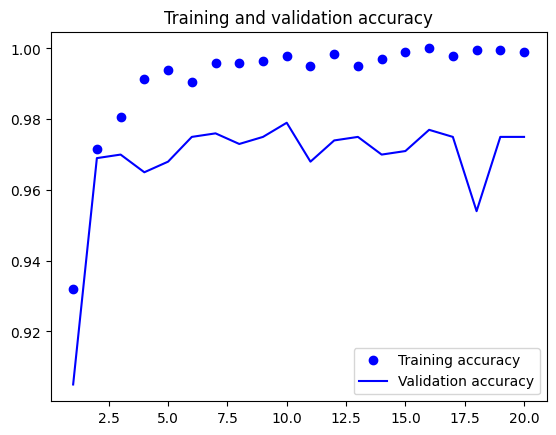

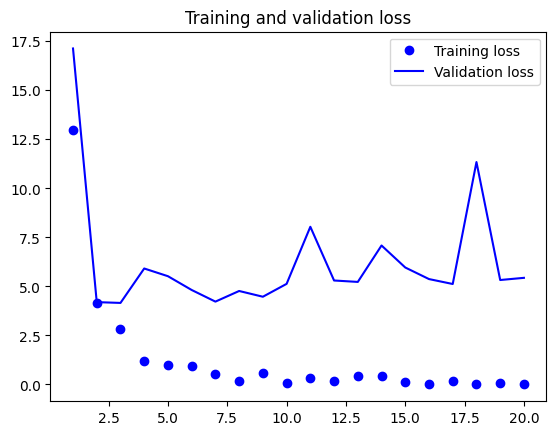

In [39]:
import matplotlib.pyplot as plt

acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)

#Accuracy Plot
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()

#Loss Plot
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

Feature extraction together with data augmentation

Instantiating and freezing the VGG16 convolutional base

In [40]:
conv_base  = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False)
conv_base.trainable = False

Printing the list of trainable weights before and after freezing



In [41]:
conv_base.trainable = True
print("This is the number of trainable weights "
      "before freezing the conv base:", len(conv_base.trainable_weights))

This is the number of trainable weights before freezing the conv base: 26


In [42]:
conv_base.trainable = False
print("This is the number of trainable weights "
      "after freezing the conv base:", len(conv_base.trainable_weights))

This is the number of trainable weights after freezing the conv base: 0


Adding a data augmentation stage and a classifier to the convolutional base



In [43]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = keras.applications.vgg16.preprocess_input(x)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

In [44]:
#Importing the Utility
from tensorflow.keras.utils import image_dataset_from_directory

#Creating Image Datasets
train_dataset = image_dataset_from_directory(
    new_base_dir / "train",
    image_size=(180, 180),
    batch_size=32)

validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation",
    image_size=(180, 180),
    batch_size=32)

test_dataset = image_dataset_from_directory(
    new_base_dir / "test",
    image_size=(180, 180),
    batch_size=32)

Found 6000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


In [45]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch_with_augmentation.keras",
        save_best_only=True,
        monitor="val_loss")
]

In [46]:
from keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor="val_loss", patience=2)
callbacks = [early_stopping]

history = model.fit(
    train_dataset,
    epochs=10,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/10
188/188 [==============================] - 26s 126ms/step - loss: 11.8781 - accuracy: 0.9237 - val_loss: 3.8542 - val_accuracy: 0.9760
Epoch 2/10
188/188 [==============================] - 22s 115ms/step - loss: 5.4842 - accuracy: 0.9530 - val_loss: 4.5212 - val_accuracy: 0.9680
Epoch 3/10
188/188 [==============================] - 21s 111ms/step - loss: 4.5624 - accuracy: 0.9587 - val_loss: 2.5600 - val_accuracy: 0.9810
Epoch 4/10
188/188 [==============================] - 22s 115ms/step - loss: 3.0514 - accuracy: 0.9607 - val_loss: 2.3989 - val_accuracy: 0.9760
Epoch 5/10
188/188 [==============================] - 22s 112ms/step - loss: 2.2369 - accuracy: 0.9600 - val_loss: 1.3951 - val_accuracy: 0.9800
Epoch 6/10
188/188 [==============================] - 22s 115ms/step - loss: 1.4286 - accuracy: 0.9663 - val_loss: 1.0521 - val_accuracy: 0.9760
Epoch 7/10
188/188 [==============================] - 23s 121ms/step - loss: 0.9871 - accuracy: 0.9678 - val_loss: 0.7350 - val_a


Evaluating the model on the test set



In [47]:
test_model = keras.models.load_model(
    "convnet_from_scratch_with_augmentation.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

32/32 [==============================] - 1s 29ms/step - loss: 0.4883 - accuracy: 0.8000
Test accuracy: 0.800


Fine Tunning

In [48]:
conv_base.summary()

#Freezing all layers until the fourth from the last

conv_base.trainable = True
for layer in conv_base.layers[:-4]:
    layer.trainable = False

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

In [49]:
# Compile the model
model.compile(
    loss="binary_crossentropy",
    optimizer=keras.optimizers.RMSprop(learning_rate=1e-4),
    metrics=["accuracy"]
)

# Define callbacks
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="fine_tuning.h5",
        save_best_only=True,
        monitor="val_loss"
    )
]

# Train the model
history = model.fit(
    train_dataset,
    epochs=15,
    validation_data=validation_dataset,
    callbacks=callbacks
)

# Load the best model
model = keras.models.load_model("fine_tuning.h5")

# Evaluate the model on test data
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")


Epoch 1/15
188/188 [==============================] - 28s 138ms/step - loss: 0.5635 - accuracy: 0.8955 - val_loss: 0.4786 - val_accuracy: 0.9190
Epoch 2/15
188/188 [==============================] - 29s 150ms/step - loss: 0.1599 - accuracy: 0.9450 - val_loss: 0.1094 - val_accuracy: 0.9680
Epoch 3/15
188/188 [==============================] - 25s 130ms/step - loss: 0.1370 - accuracy: 0.9532 - val_loss: 0.3002 - val_accuracy: 0.9370
Epoch 4/15
188/188 [==============================] - 25s 133ms/step - loss: 0.1065 - accuracy: 0.9638 - val_loss: 0.0676 - val_accuracy: 0.9790
Epoch 5/15
188/188 [==============================] - 27s 145ms/step - loss: 0.0908 - accuracy: 0.9672 - val_loss: 0.1676 - val_accuracy: 0.9680
Epoch 6/15
188/188 [==============================] - 25s 133ms/step - loss: 0.0799 - accuracy: 0.9725 - val_loss: 0.0814 - val_accuracy: 0.9710
Epoch 7/15
188/188 [==============================] - 25s 132ms/step - loss: 0.0782 - accuracy: 0.9760 - val_loss: 0.1282 - val_ac

In [50]:
#Importing Modules
import os, shutil, pathlib

#Setting Up Paths
original_dir = pathlib.Path("train")
new_base_dir = pathlib.Path("cats_vs_dogs_small")

#Defining a Function to Create Subsets
def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir)
        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=original_dir / fname,
                            dst=dir / fname)


make_subset("train2", start_index=1000, end_index=2000)

train_dataset_2 = image_dataset_from_directory(
new_base_dir / "train2",
image_size=(180, 180),
batch_size=32)

make_subset("train3", start_index=1000, end_index=2000)

train_dataset_3 = image_dataset_from_directory(
new_base_dir / "train3",
image_size=(180, 180),
batch_size=32)

Found 2000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


In [51]:
history = model.fit(
train_dataset_2,
epochs=15,
validation_data=validation_dataset,
callbacks=callbacks)

Epoch 1/15
63/63 [==============================] - 14s 192ms/step - loss: 0.0814 - accuracy: 0.9715 - val_loss: 0.1073 - val_accuracy: 0.9740
Epoch 2/15
63/63 [==============================] - 13s 196ms/step - loss: 0.0853 - accuracy: 0.9720 - val_loss: 0.0717 - val_accuracy: 0.9810
Epoch 3/15
63/63 [==============================] - 11s 160ms/step - loss: 0.0524 - accuracy: 0.9820 - val_loss: 0.1774 - val_accuracy: 0.9770
Epoch 4/15
63/63 [==============================] - 11s 172ms/step - loss: 0.0831 - accuracy: 0.9755 - val_loss: 0.1132 - val_accuracy: 0.9810
Epoch 5/15
63/63 [==============================] - 12s 192ms/step - loss: 0.0568 - accuracy: 0.9845 - val_loss: 0.1499 - val_accuracy: 0.9820
Epoch 6/15
63/63 [==============================] - 11s 166ms/step - loss: 0.0533 - accuracy: 0.9850 - val_loss: 0.1512 - val_accuracy: 0.9770
Epoch 7/15
63/63 [==============================] - 10s 162ms/step - loss: 0.0554 - accuracy: 0.9835 - val_loss: 0.8662 - val_accuracy: 0.9410

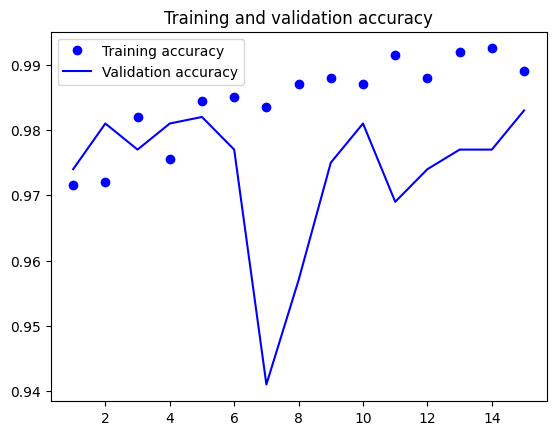

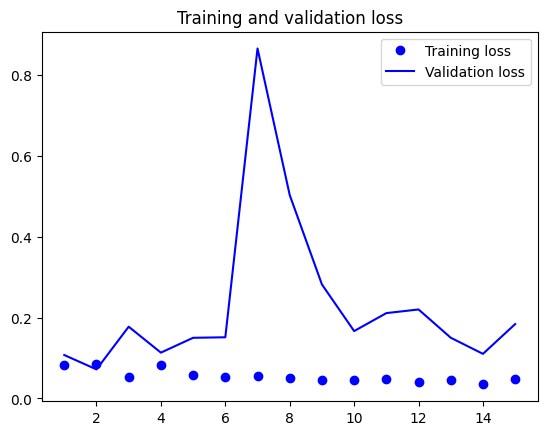

In [52]:
import matplotlib.pyplot as plt

acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)

#Accuracy Plot
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()

#Loss Plot
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [53]:
# Load the best model
model = keras.models.load_model("fine_tuning.h5")

test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

32/32 [==============================] - 3s 90ms/step - loss: 0.1310 - accuracy: 0.9720
Test accuracy: 0.972


In [54]:
history = model.fit(
train_dataset_3,
epochs=15,
validation_data=validation_dataset,
callbacks=callbacks)

Epoch 1/15
63/63 [==============================] - 13s 170ms/step - loss: 0.1266 - accuracy: 0.9735 - val_loss: 0.0767 - val_accuracy: 0.9780
Epoch 2/15
63/63 [==============================] - 12s 191ms/step - loss: 0.0759 - accuracy: 0.9775 - val_loss: 0.0878 - val_accuracy: 0.9780
Epoch 3/15
63/63 [==============================] - 11s 162ms/step - loss: 0.0733 - accuracy: 0.9765 - val_loss: 0.0994 - val_accuracy: 0.9740
Epoch 4/15
63/63 [==============================] - 11s 164ms/step - loss: 0.0605 - accuracy: 0.9820 - val_loss: 0.0931 - val_accuracy: 0.9760
Epoch 5/15
63/63 [==============================] - 13s 196ms/step - loss: 0.0666 - accuracy: 0.9785 - val_loss: 0.1525 - val_accuracy: 0.9740
Epoch 6/15
63/63 [==============================] - 11s 169ms/step - loss: 0.0696 - accuracy: 0.9810 - val_loss: 0.1075 - val_accuracy: 0.9780
Epoch 7/15
63/63 [==============================] - 10s 159ms/step - loss: 0.0324 - accuracy: 0.9885 - val_loss: 0.1653 - val_accuracy: 0.9800

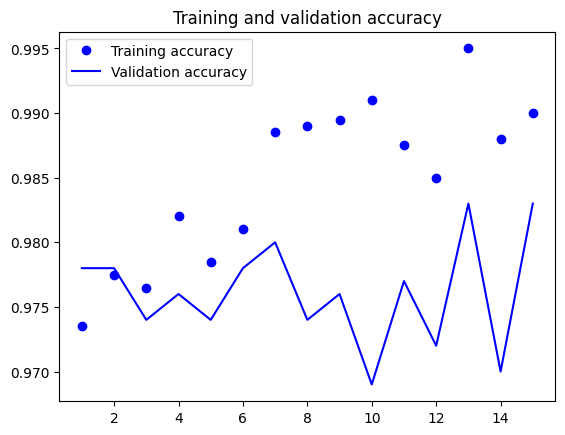

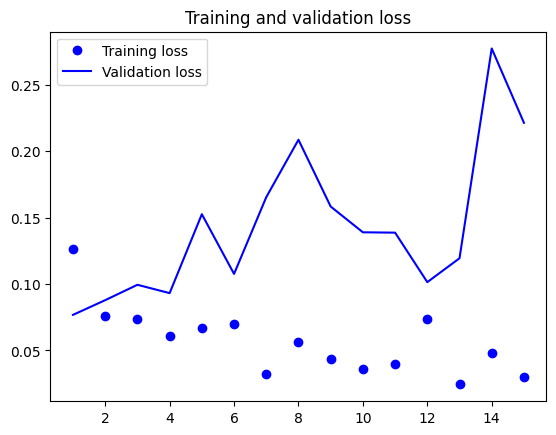

In [55]:
import matplotlib.pyplot as plt

acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)

#Accuracy Plot
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()

#Loss Plot
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [56]:
# Load the best model
model = keras.models.load_model("fine_tuning.h5")

test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

32/32 [==============================] - 3s 90ms/step - loss: 0.1310 - accuracy: 0.9720
Test accuracy: 0.972


In [ ]:
END